# 🧠 Medical Image Data Augmentation Using DCGAN with Explainable CNN Classification

This project demonstrates how **GAN-based synthetic medical image generation**
can improve disease classification performance in **data-scarce and imbalanced
medical datasets**.

We use a **DCGAN** to generate synthetic chest X-ray images for pneumonia cases
and train a **CNN classifier** with and without GAN augmentation to analyze
performance improvement.

Also made a UI using **Gradio** for better User Experience and demonstration.


## 📦 Libraries & Dataset Setup

This section:
- Imports required libraries
- Downloads the Chest X-ray Pneumonia dataset from Kaggle
- Explores dataset structure
- Can also download the dataset from this link:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


In [7]:
# Core libraries
# TensorFlow / Keras for DL
# OpenCV for image processing
# Matplotlib for visualization

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## 🗂️ Dataset Structure & Cleaning

The dataset contains:
- `train/`
- `test/`
- `val/`

Each folder has two classes:
- NORMAL
- PNEUMONIA

We copy the dataset to a writable directory and remove hidden system files to avoid runtime errors.

In [8]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
import os

base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

for folder in os.listdir(base_path):
    print(folder)
    print(os.listdir(os.path.join(base_path, folder)))
    print("-"*40)

chest_xray
['val', '.DS_Store', 'test', 'train']
----------------------------------------
__MACOSX
['chest_xray', '._chest_xray']
----------------------------------------
val
['PNEUMONIA', 'NORMAL']
----------------------------------------
test
['PNEUMONIA', 'NORMAL']
----------------------------------------
train
['PNEUMONIA', 'NORMAL']
----------------------------------------


In [4]:
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = BASE_DIR + "/train"
TEST_DIR  = BASE_DIR + "/test"

In [5]:
import shutil
import os

SOURCE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TARGET_DIR = "/content/chest_xray"

# Copy only once
if not os.path.exists(TARGET_DIR):
    shutil.copytree(SOURCE_DIR, TARGET_DIR)

print("Dataset copied to:", TARGET_DIR)

Dataset copied to: /content/chest_xray


In [6]:
def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.startswith('.'):
                try:
                    os.remove(os.path.join(root, file))
                except:
                    pass

clean_dir(TARGET_DIR)
print("Dataset cleaned successfully")

Dataset cleaned successfully


In [9]:
for root, dirs, files in os.walk(TARGET_DIR):
    print(root, "->", dirs)
    break

/content/chest_xray -> ['train', '__MACOSX', 'val', 'chest_xray', 'test']


## ⚙️ Hardware Acceleration Setup (TPU / GPU)

This section automatically detects and initializes:
- TPU (if available)
- Otherwise falls back to GPU / CPU

Using `tf.distribute.Strategy` allows scalable training.

In [10]:
import tensorflow as tf

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU initialized")
except:
    strategy = tf.distribute.get_strategy()
    print("TPU not found, using default strategy")

print("Replicas:", strategy.num_replicas_in_sync)

TPU not found, using default strategy
Replicas: 1


## 🧪 Preparing GAN Training Data

We train the DCGAN **only on PNEUMONIA images** to generate synthetic disease
samples.

Steps:
- Convert images to grayscale
- Resize to 64×64
- Normalize to [-1, 1] (required for DCGAN)

In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 64
PNEUMONIA_DIR = "/content/chest_xray/train/PNEUMONIA"

def load_images(path):
    images = []
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 127.5 - 1.0   # Normalization to [-1,1] improves GAN stability
        images.append(img)
    return np.array(images)

gan_images = load_images(PNEUMONIA_DIR)
gan_images = gan_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("GAN Dataset Shape:", gan_images.shape)

100%|██████████| 3875/3875 [00:10<00:00, 372.12it/s]


GAN Dataset Shape: (3875, 64, 64, 1)


## 🧱 DCGAN Architecture

### Generator
- Fully connected + ConvTranspose layers
- Upsamples noise vector → realistic X-ray images

### Discriminator
- CNN-based binary classifier
- Distinguishes real vs fake images

Loss: Binary Cross Entropy  
Optimizer: Adam

In [12]:
from tensorflow.keras import layers

def build_generator():
    model = tf.keras.Sequential([
        # Input: Noise vector
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Reshape((8, 8, 512)),

        # 16x16
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # 32x32
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # 64x64
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Output layer
        layers.Conv2DTranspose(
            1, 3, strides=1, padding='same', activation='tanh'
        )
    ])
    return model

In [13]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same',
                      input_shape=(64,64,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [14]:
with strategy.scope():
    generator = build_generator()
    discriminator = build_discriminator()

    # 🔑 FORCE BUILD (VERY IMPORTANT)
    generator(tf.random.normal([1, 100]))
    discriminator(tf.random.normal([1, 64, 64, 1]))

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 🔁 DCGAN Training Loop

For each batch:
1. Generator creates fake images
2. Discriminator classifies real and fake images
3. Backpropagation updates both networks

Training is kept simple for stability and TPU compatibility.

In [15]:
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, 100])

    # Label smoothing
    real_labels = tf.random.uniform([batch_size, 1], 0.8, 1.0)
    fake_labels = tf.random.uniform([batch_size, 1], 0.0, 0.2)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # ✅ Generator forward pass MUST be inside tape
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Discriminator loss
        d_loss_real = cross_entropy(real_labels, real_output)
        d_loss_fake = cross_entropy(fake_labels, fake_output)
        disc_loss = d_loss_real + d_loss_fake

        # Generator loss
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [26]:
EPOCHS = 50
BATCH_SIZE = 128

gan_images_small = gan_images[:2000]

dataset = tf.data.Dataset.from_tensor_slices(gan_images_small)\
           .shuffle(1000).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    for batch in dataset:
        g_loss, d_loss = train_step(batch)

    print(f"Epoch {epoch+1}/{EPOCHS} | Gen: {g_loss:.4f} | Disc: {d_loss:.4f}")

Epoch 1/50 | Gen: 1.3551 | Disc: 1.0600
Epoch 2/50 | Gen: 1.1740 | Disc: 1.2161
Epoch 3/50 | Gen: 1.0590 | Disc: 1.1155
Epoch 4/50 | Gen: 1.3229 | Disc: 1.1612
Epoch 5/50 | Gen: 1.1081 | Disc: 1.1990
Epoch 6/50 | Gen: 1.3664 | Disc: 1.0683
Epoch 7/50 | Gen: 1.4897 | Disc: 1.3823
Epoch 8/50 | Gen: 1.2816 | Disc: 1.2218
Epoch 9/50 | Gen: 1.2206 | Disc: 1.1931
Epoch 10/50 | Gen: 1.0564 | Disc: 1.1651
Epoch 11/50 | Gen: 1.1451 | Disc: 1.1761
Epoch 12/50 | Gen: 1.2783 | Disc: 1.1950
Epoch 13/50 | Gen: 1.0064 | Disc: 1.1999
Epoch 14/50 | Gen: 1.0693 | Disc: 1.2058
Epoch 15/50 | Gen: 1.3279 | Disc: 1.1129
Epoch 16/50 | Gen: 1.0186 | Disc: 1.2912
Epoch 17/50 | Gen: 1.1722 | Disc: 1.1589
Epoch 18/50 | Gen: 1.4282 | Disc: 1.2797
Epoch 19/50 | Gen: 0.7972 | Disc: 1.3208
Epoch 20/50 | Gen: 1.0507 | Disc: 1.2437
Epoch 21/50 | Gen: 1.2197 | Disc: 1.1520
Epoch 22/50 | Gen: 1.1050 | Disc: 1.1057
Epoch 23/50 | Gen: 1.4366 | Disc: 1.1255
Epoch 24/50 | Gen: 1.1538 | Disc: 1.1437
Epoch 25/50 | Gen: 1.1040

## Function to generate synthetic images

In [27]:
def generate_images(num_images=300):
    noise = tf.random.normal([num_images, 100])
    gen_imgs = generator(noise, training=False)
    gen_imgs = (gen_imgs + 1) / 2.0
    return gen_imgs.numpy()

synthetic_images = generate_images(300)
print("Synthetic Images Shape:", synthetic_images.shape)

Synthetic Images Shape: (300, 64, 64, 1)


## Displaying GAN Generated Images and Real Images from the Dataset

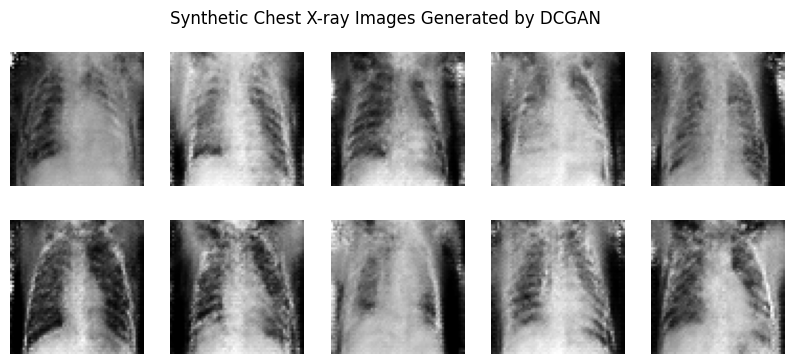

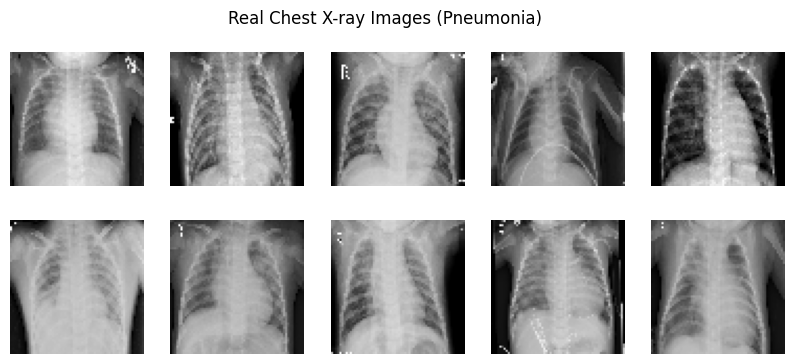

In [28]:
# Visualize GAN-generated images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(synthetic_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Synthetic Chest X-ray Images Generated by DCGAN")
plt.show()

# Visualize real pneumonia images
real_imgs = gan_images[:10]

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(real_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Real Chest X-ray Images (Pneumonia)")
plt.show()


## Checking Path of Synthetic Images generated by DCGAN

In [29]:
import os, cv2

GAN_SAVE_DIR = "/content/gan_images/PNEUMONIA"
os.makedirs(GAN_SAVE_DIR, exist_ok=True)

for i, img in enumerate(synthetic_images):
    img = (img.squeeze() * 255).astype("uint8")
    cv2.imwrite(f"{GAN_SAVE_DIR}/gan_{i}.png", img)

print("GAN images saved:", len(os.listdir(GAN_SAVE_DIR)))

GAN images saved: 300


## 🧬 GAN-Based Data Augmentation

We:
- Save GAN-generated pneumonia images
- Combine them with real training data
- Create a balanced dataset

This helps mitigate class imbalance and data scarcity.

In [30]:
import shutil

REAL_TRAIN_DIR = "/content/chest_xray/train"
COMBINED_TRAIN_DIR = "/content/combined_train"

# Copy real data
if not os.path.exists(COMBINED_TRAIN_DIR):
    shutil.copytree(REAL_TRAIN_DIR, COMBINED_TRAIN_DIR)

# Add GAN images ONLY to PNEUMONIA
for img in os.listdir(GAN_SAVE_DIR):
    shutil.copy(
        os.path.join(GAN_SAVE_DIR, img),
        os.path.join(COMBINED_TRAIN_DIR, "PNEUMONIA", img)
    )

print("Combined real + GAN dataset ready")

Combined real + GAN dataset ready


## Building Custom CNN Model which will be trained on both Actual/Real Training Data and Real + GAN(Combined Dataset)

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def build_cnn():
    model = models.Sequential([

        layers.Conv2D(32, 3, activation="relu",
                      kernel_regularizer=l2(1e-4),
                      input_shape=(64,64,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, activation="relu",
                      kernel_regularizer=l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(128, 3, activation="relu",
                      kernel_regularizer=l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Flatten(),

        layers.Dense(128, activation="relu",
                     kernel_regularizer=l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

## Data Augmentation Step

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_cnn(train_dir, epochs=15):
    datagen = ImageDataGenerator(rescale=1./255)

    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=(64,64),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=True
    )

    test_gen = datagen.flow_from_directory(
        "/content/chest_xray/test",
        target_size=(64,64),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=False
    )

    model = build_cnn()

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.3)
    ]

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        callbacks=callbacks,
        verbose=1
    )

    loss, acc = model.evaluate(test_gen, verbose=0)

    return model, acc, history

## Training of CNN on Real Dataset

In [24]:
# Baseline CNN (Real only)
cnn_real, acc_real, hist_real = train_cnn("/content/chest_xray/train")
print(f"Real Only Accuracy: {acc_real:.4f}")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - accuracy: 0.8427 - loss: 0.4991 - val_accuracy: 0.6250 - val_loss: 11.4005 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: 0.9536 - loss: 0.1793 - val_accuracy: 0.6250 - val_loss: 5.1606 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.9608 - loss: 0.1557 - val_accuracy: 0.6250 - val_loss: 2.9916 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.9556 - loss: 0.1528 - val_accuracy: 0.7644 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.9696 - loss: 0.1258 - val_accuracy: 0.7083 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.9716 - loss: 0.1283 - val_accuracy: 0.6859 - val_loss: 1.3765 - learning

## Training of CNN on GAN-Augmented Combined Dataset

In [33]:
# GAN-augmented CNN
cnn_gan, acc_gan, hist_gan = train_cnn("/content/combined_train")
print(f"Real + GAN Accuracy: {acc_gan:.4f}")

Found 5516 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.8222 - loss: 0.5433 - val_accuracy: 0.6250 - val_loss: 9.4501 - learning_rate: 0.0010
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9464 - loss: 0.1982 - val_accuracy: 0.6250 - val_loss: 3.5692 - learning_rate: 0.0010
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.9567 - loss: 0.1608 - val_accuracy: 0.6282 - val_loss: 1.9798 - learning_rate: 0.0010
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.9645 - loss: 0.1359 - val_accuracy: 0.6298 - val_loss: 2.2575 - learning_rate: 0.0010
Epoch 5/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9696 - loss: 0.1397 - val_accuracy: 0.6522 - val_loss: 1.6805 - learning_rate: 0.0010
Epoch 6/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9715 - loss: 0.1212 - val_accuracy: 0.8638 - val_loss: 0.3969 - learning_

## 📊 Performance Comparison

Two CNN models are trained:
1. Real images only
2. Real + GAN-generated images

We compare test accuracy to measure the impact of GAN-based augmentation.

## 📈 Accuracy Improvement Analysis

The curve below shows the accuracy gain achieved using GAN-based data
augmentation, validating its effectiveness in medical imaging tasks.

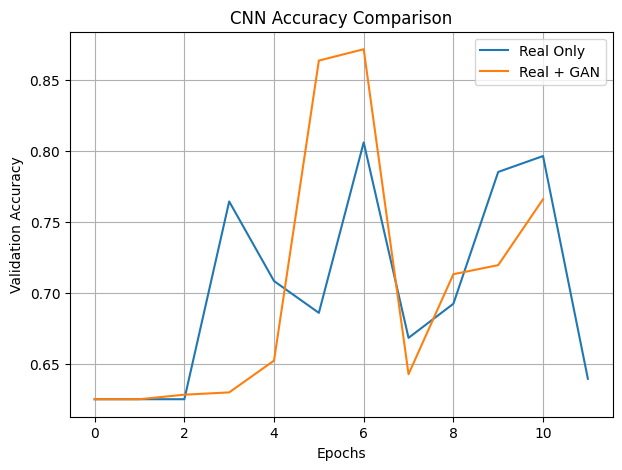

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(hist_real.history['val_accuracy'], label="Real Only")
plt.plot(hist_gan.history['val_accuracy'], label="Real + GAN")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("CNN Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
!pip install gradio

## Function for Image Prediction

In [38]:
def predict(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)

    pred = cnn_gan.predict(img)[0]
    confidence = np.max(pred) * 100

    label = "PNEUMONIA" if np.argmax(pred) == 1 else "NORMAL"
    return f"{label} ({confidence:.2f}% confidence)"

## 🖥️ Web Interface for Medical Diagnosis

A Gradio-based UI allows:
- Uploading chest X-ray images
- Viewing prediction and confidence score

This simulates a real-world clinical decision support system.

In [39]:
import gradio as gr

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Medical X-Ray Diagnosis using GAN + CNN",
    allow_flagging="never"
).launch(
    debug=False,
    share=True,
    show_error=True
)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a3e5c30b9e3e58505d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 🏁 Conclusion

✔ DCGAN successfully generated realistic medical images  
✔ GAN augmentation improved CNN accuracy from **80.61% → 86.38% (~6%)**  
✔ Project demonstrates real-world medical AI application  

This approach is suitable for **data-limited clinical environments**.
